<a href="https://colab.research.google.com/github/ramonVDAKKER/teaching-quantitative-finance/blob/main/notebooks/illustration_black_scholes_price.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Illustration Black-Scholes prices for European call and put options

In [ ]:
import numpy as np
import pandas as pd
from scipy.stats import norm
from ipywidgets import interact
import matplotlib.pyplot as plt

In the standard Black-Scholes market two assets are traded. A risky asset (stock) is traded with price process described by the SDE 
$$dS_t = \mu S_t dt +\sigma S_t dW_t,$$ where $S_0=s_0$, $W$ is a standard Brownian motion, and $\mu,\sigma>0$. The second asset is a money-market-account described by $dB_t = r B_t dt$ where $r$ denotes the (deterministic) interest. As usual, 'frictionless' trading is assumed (no restrictions on short selling, no restrictions on fractional positions, trading in continuous-time, no transaction costs). 

Under these assumptions the price of a European put option, at time $t\in[0, T)$, with (remaining) time-to-expiration/maturity $T-t$ and strike $K>0$ is given by
$$p_t = \operatorname{e}^{-r(T-t)}  K \Phi( -d_2) - S_t \Phi ( - d_1),$$
where
$$d_1 = \frac{\log( S_t / K) + ( r + 0.5\sigma^2 )( T-t)}{\sigma \sqrt{T-t}}
\text{ and }   d_2 = d_1 - \sigma \sqrt{T-t}.$$
And the price of a call option (with the same specs) is given by
$$c_t = S_t \Phi(d_1) - \operatorname{e}^{-r(T-t)}  K \Phi( d_2).$$

Please note that we can write $c_t = f(T-t, S_t)$ and $p_t =g(T-t,S_t)$ for suitable functions $f$ and $g$.

In [ ]:
class BlackScholesOptionPrice():
    """Class for Black-Scholes price of European put and call options."""

    def __init__(self, strike: float, r: float, sigma: float):
        
        self.r = r
        self.sigma = sigma
        self.strike = strike

    def _d1_and_d2(self, current_stock_price, time_to_maturity):
        """Calculates auxiliary d_1 and d_2 which enter the N(0, 1) cdf in the pricing formulas"""
        
        d1 = (np.log(current_stock_price / self.strike) + (self.r + 0.5 * self.sigma ** 2) * time_to_maturity) / (self.sigma * np.sqrt(time_to_maturity))
        d2 = d1 - self.sigma * np.sqrt(time_to_maturity)
        return d1, d2

    def price_put(self, current_stock_price, time_to_maturity):
        """Calculates price of European put option"""

        d1, d2 = self._d1_and_d2(current_stock_price, time_to_maturity)
        return np.exp(-self.r * time_to_maturity) * self.strike * norm.cdf(-d2) - current_stock_price * norm.cdf(-d1)

    def price_call(self, current_stock_price, time_to_maturity):
        """Calculates price of European call option"""

        d1, d2 = self._d1_and_d2(current_stock_price, time_to_maturity)
        return current_stock_price * norm.cdf(d1) - np.exp(-self.r * time_to_maturity) * self.strike *  norm.cdf(d2)

In [ ]:
strike = 100
r = 0.02
sigma = 0.2
current_stock_price = 100
time_to_maturity = 1
bs = BlackScholesOptionPrice(strike, r, sigma)
price = bs.price_put(current_stock_price, time_to_maturity)
print(f"Price of put for strike={strike}, r={100 * r}%, sigma={100 * sigma}%, S_t={current_stock_price}, T-t={time_to_maturity}: {np.round(price , 2)}")

Price of put for strike=100, r=2.0%, sigma=20.0%, S_t=100, T-t=1: 6.94


In the following plot we fix the time-to-maturity/expiration and consider the price of the call option as function of the current stock price.

In [ ]:
@interact(r=(0, 0.1), sigma=(0.01, 0.8), strike=(50, 110), time_to_maturity=(0.01, 2))
def aux_plot(strike, r, sigma, time_to_maturity):
    bs = BlackScholesOptionPrice(strike, r, sigma)
    current_stock_price = np.linspace(0.01, 200, 2000)
    price = bs.price_put(current_stock_price, time_to_maturity)
    pd.Series(price, index=current_stock_price).plot(figsize=(25, 7), title=f"Price put option as function of $S_t$, r={100 * r}%, sigma={100 * sigma}%, K={K}, T-t={time_to_maturity}", xlabel="S_t", ylabel="put price")

interactive(children=(IntSlider(value=80, description='strike', max=110, min=50), FloatSlider(value=0.05, desc…

In the following plots we first simulate paths of a Geometric Brownian motion, on $[0,T]$, and evaluate the evolution of the price of a put option.

In [ ]:
class GeometricBrownianMotion():
    """Class to simulate paths of a Geometric Brownian motion, i.e. X_t=X_0\exp((mu-0.5sigma^2)t+sigma*W_t)"""

    def __init__(self, starting_value, mu, sigma, n, T, time_step, seed=None):

        self.name = "Geometric Brownian Motion"
        self.n = n
        self.T = T
        self.starting_value = starting_value
        self.time_grid, self.time_step = np.linspace(
            0, self.T, num=1 + int(T / time_step), endpoint=True, retstep=True
        )  # note that time_step is adapted (if needed) in order to get equally-spaced grid
        if seed is not None:
            np.random.seed(seed)
        aux = np.random.normal(loc=0.0, scale=1.0, size=(self.n, len(self.time_grid)-1))
        aux = np.concatenate([np.zeros((self.n, 1)), aux], axis=1)
        W = (
            np.cumsum(sigma * np.sqrt(time_step) * aux, axis=1) 
        )
        self.paths = starting_value * np.exp( (mu - 0.5 * sigma ** 2) * self.time_grid + W)
    
    def plot(self):

        title = f"Simulated sample paths from GBM"
        pd.DataFrame(
            self.paths.T,
            columns=[f"path {j}" for j in range(1, 1 + len(self.paths))],
            index=self.time_grid,
        ).plot(kind="line", title=title, figsize=(25, 7))


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: RuntimeWarning: divide by zero encountered in true_divide
  del sys.path[0]


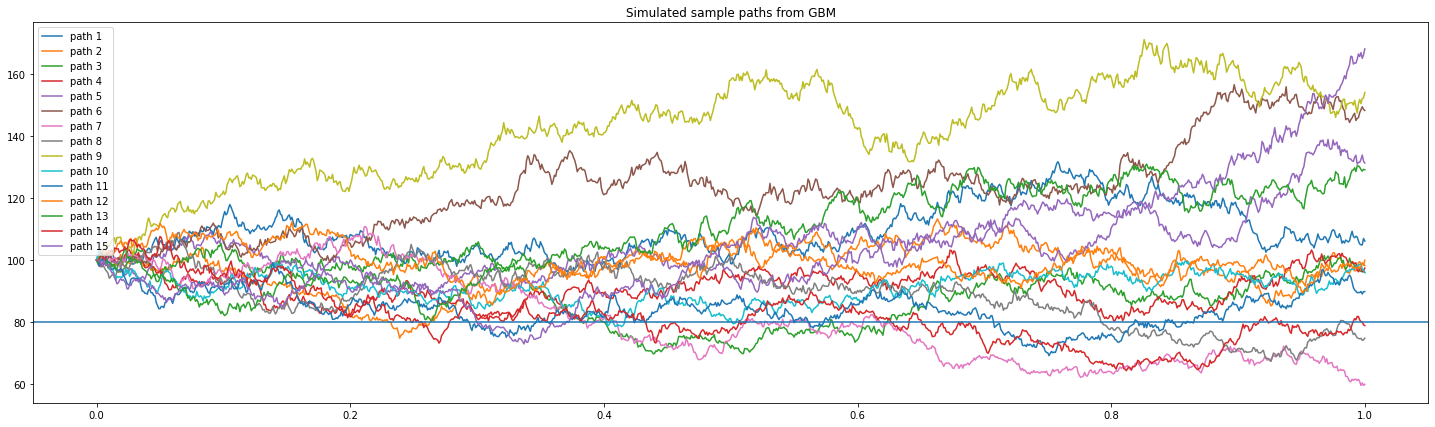

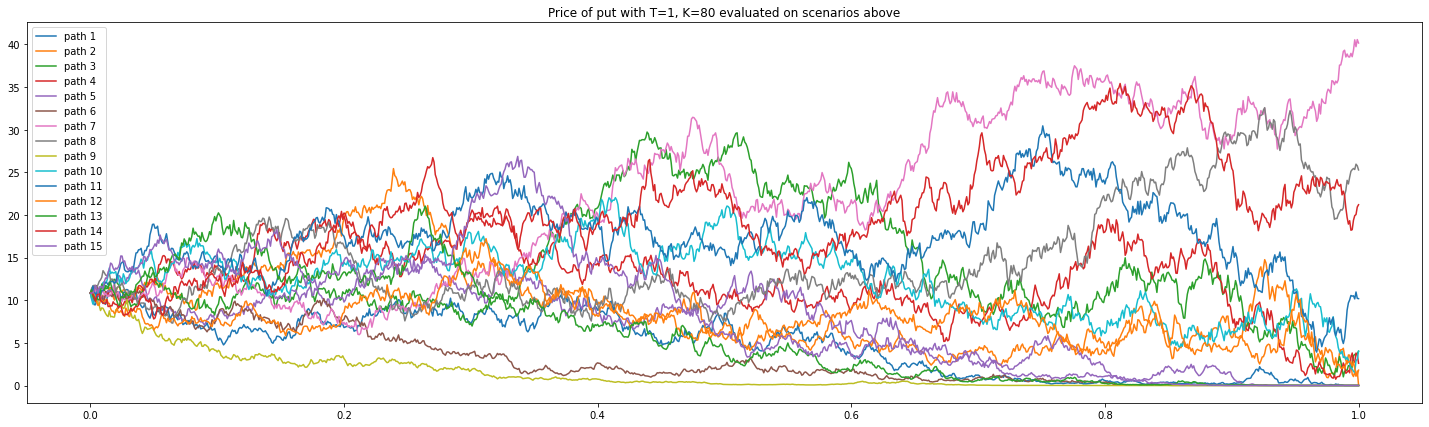

In [ ]:
# option parameters:
K = 80
T = 1
# stock price parameters:
starting_value = 100
mu = 0.1
sigma = 0.3
r = 0.02
# simulation setting:
n = 15
time_step = 0.001
gbm = GeometricBrownianMotion(starting_value, mu, sigma, n, T, time_step, seed=None)
gbm.plot()
plt.axhline(K)
bs = BlackScholesOptionPrice(strike, r, sigma)
price = bs.price_put(gbm.paths, T - gbm.time_grid)
pd.DataFrame(price.T, index=gbm.time_grid, columns=[f"path {j}" for j in range(1, 1 + len(gbm.paths))]).plot(figsize=(25, 7), title=f"Price of put with T={T}, K={K} evaluated on scenarios above")